# MCT4052 Workshop 5c: Audio Files + LDA + SVM Classifier

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

The notebooks Workshop 5b to 5h integrates a stage of dimensionality reduction with different type of machine learning technique (classification, regression, clustering) on audio or MIDI data. The machine learning techniques included in this set of examples are those from previous workshops.

In [1]:
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import sklearn

%matplotlib notebook
%config IPCompleter.greedy=True

In [2]:
sr = 22050


def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output


def extract_features(filename, sr):
    
    signal, dummy = librosa.load(filename, sr, mono=True)

    temp = librosa.feature.melspectrogram(signal, n_mels=13)
    
    melspect = lin_interp_2d(temp, (5,13))
    
    output = melspect.flatten()
    
    return output


filenames = os.listdir('./data/examples2')
num_of_features = len(extract_features('./data/examples2/'+filenames[0], sr))
features = np.zeros((len(filenames),num_of_features)) 
labels = np.zeros((len(filenames))) 
classes = ['kick','snare','cymbal','clap'] 

for i in range(len(filenames)):
    features[i,:] = extract_features('./data/examples2/'+filenames[i], sr)
    if filenames[i].find('kick') != -1:
        labels[i] = 0
    elif filenames[i].find('snare') != -1:
        labels[i] = 1
    elif filenames[i].find('cymbal') != -1:
        labels[i] = 2
    elif filenames[i].find('clap') != -1:
        labels[i] = 3
        
print('Done!')

Done!


In [3]:
#this step converts the labels from a numpy array to 
#a Pandas series, which allows backtracing misclassified examples
#scikitlearn can handle features or labels also as Pandas formats
labels = pd.Series(labels)

In [4]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=7)

In [5]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

<IPython.core.display.Javascript object>


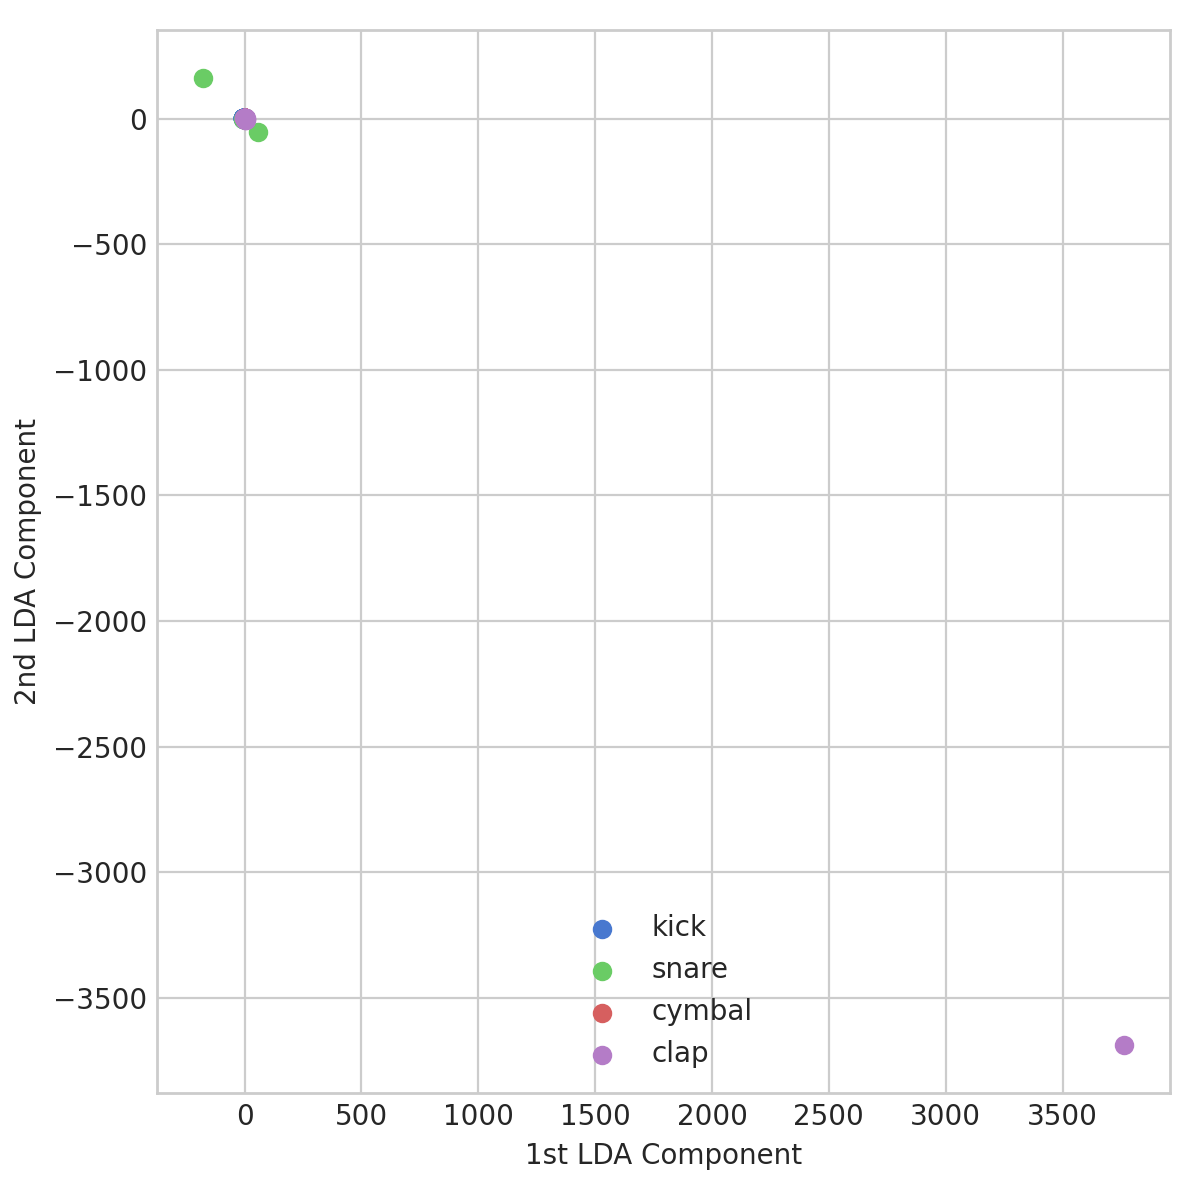

In [6]:
#Creating an instance of the LDA object, which is an object capable of learning and applying LDA from/to data.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#lda will keep a number of components equal to number of classes -1
lda = LinearDiscriminantAnalysis()


#This will learn LDA projection from train data
lda.fit(feat_train,lab_train)

#Now we project the data using LDA
projected_features_train = lda.transform(feat_train)
projected_features_test = lda.transform(feat_test)

#this is only for scatter plot purposes
projected_features = lda.transform(scaler.transform(features))


#Plot the distribution of the data according to the first two principle components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 0],
                    projected_features[labels==lab_val, 1],
                    label=lab_name)
    plt.xlabel('1st LDA Component')
    plt.ylabel('2nd LDA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()
    
# for a proper data visualization, zoom in in the area with high density of points

In [7]:
#Creating an instance of a SVM classifier
model_SVM = sklearn.svm.SVC(kernel='rbf', C=2.0)

#training the model
model_SVM.fit(projected_features_train, lab_train)

#applying the the model on the test data (features)
lab_predict = model_SVM.predict(projected_features_test)


#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Number of mislabeled samples 6 out of 34
Accuracy: 0.8235294117647058


In [8]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

print(sklearn.metrics.confusion_matrix(lab_test, lab_predict))

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        10
         1.0       0.50      0.33      0.40         3
         2.0       0.91      1.00      0.95        10
         3.0       0.80      0.73      0.76        11

    accuracy                           0.82        34
   macro avg       0.76      0.74      0.74        34
weighted avg       0.81      0.82      0.81        34

[[ 9  1  0  0]
 [ 0  1  0  2]
 [ 0  0 10  0]
 [ 2  0  1  8]]


In [9]:
#displaying names of misclassified files
results = lab_test == lab_predict
for index, value in results.items():
    if value == False:
        print(filenames[index])


clap39.wav
clap28.wav
kick_31.wav
snare_19.wav
clap03.wav
snare_06.wav
